In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from pandas.core import indexing
from pathos.pools import ProcessPool
from scipy import linalg, interpolate
from scipy.special import gamma
import scipy as sci
from sklearn import gaussian_process as gp
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import h5py
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap, random
import jax.scipy as jsci
from jax.ops import index, index_add, index_update, index_mul
sys.path.append('../DeepONetsPI/')  # add the pde package to the python path
from spaces_nd import GRF_nd, construct_grid, construct_points
jax.config.update("jax_enable_x64", True)




In [2]:
def RBF(x1, x2, length_scale=0.1, output_scale=1.0):
    # output_scale, lengthscales = params
    diffs = jnp.expand_dims(x1 / length_scale, 1) - \
            jnp.expand_dims(x2 / length_scale, 0)
    r2 = jnp.sum(diffs**2, axis=2)
    return output_scale * jnp.exp(-0.5 * r2)

In [3]:
def RBF_sin(x1, x2, length_scale=0.1, output_scale=1.0):
    # output_scale, lengthscales = params
    diffs = jnp.expand_dims(jnp.sin(2.0*jnp.pi*x1/2.0)**2 / length_scale, 1) - \
            jnp.expand_dims(jnp.sin(2.0*jnp.pi*x2/2.0)**2 / length_scale, 0)
    r2 = jnp.sum(diffs**2, axis=2)
    return output_scale * jnp.exp(-0.5 * r2)

In [4]:
def KernPer(x1, x2, length_scale=0.1, output_scale=1.0, period=1.0):
    # output_scale, lengthscales = params
    diffs = jnp.expand_dims(x1, 1) - \
            jnp.expand_dims(x2, 0)
    r2 = jnp.sum(-2.0*(jnp.sin(jnp.pi * jnp.abs(diffs)/period)/length_scale)**2, axis=2)
    return output_scale * jnp.exp(-r2)

In [5]:
# num = 1
dim = 2
N = 50
N_full = jnp.array([N]*dim)
Ntot = jnp.prod(N_full)
length_scale = 0.1
jitter = 1e-13
x = [jnp.linspace(0, 1, N) for i in range(dim)]
grid = jnp.meshgrid(*x, indexing='ij')
X = jnp.zeros((Ntot, dim))
for i in range(dim):
    X = X.at[:,i].set(grid[i].ravel())
# X = jnp.linspace(0, 1, N)[:, None]


In [6]:

K = RBF(X, X, length_scale=length_scale)
L = jnp.linalg.cholesky(K + jitter*jnp.eye(Ntot))


In [7]:
X

DeviceArray([[0.        , 0.        ],
             [0.        , 0.02040816],
             [0.        , 0.04081633],
             ...,
             [1.        , 0.95918367],
             [1.        , 0.97959184],
             [1.        , 1.        ]], dtype=float64)

In [8]:
key = random.PRNGKey(1234578)
u_rand = random.normal(key, (Ntot,))
sample = jnp.dot(L, u_rand).T
jnp.float32(sample).shape

(2500,)

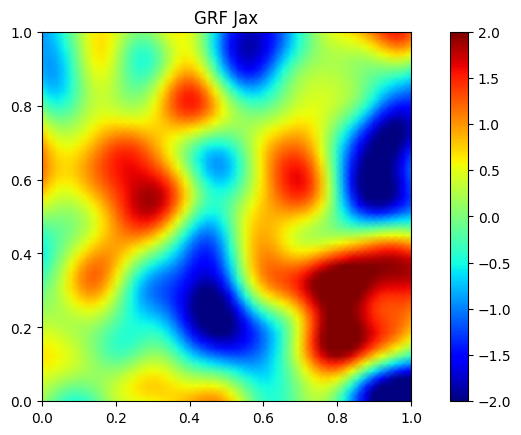

In [9]:
fig = plt.figure()
if dim == 2:
    grid, U = construct_grid(X, sample, shape=N_full)
    X1, X2 = grid
    c = plt.pcolormesh(X1, X2, U, cmap='jet', shading='gouraud', vmin=-2, vmax=2)
    fig.colorbar(c)
    plt.title('GRF Jax')
    plt.axis('square')
elif dim == 1:
    plt.plot(X, sample)
plt.show()

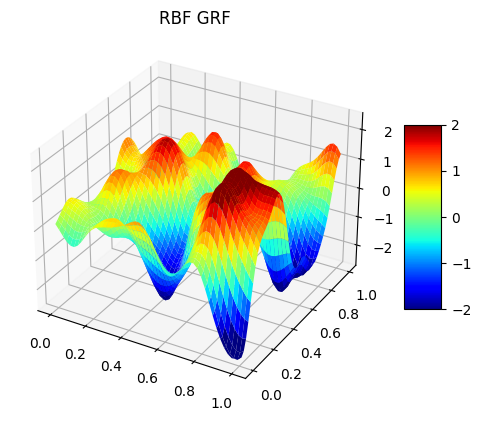

In [10]:
if dim == 2:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    grid, U = construct_grid(X, sample, shape=N_full)
    X1, X2 = grid
    surf = ax.plot_surface(X1, X2, U, cmap='jet', linewidth=0, antialiased=True, vmin=-2, vmax=2)
    # c = plt.pcolormesh(X1, X2, U, cmap='jet', shading='gouraud')
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('RBF GRF')
    # plt.axis('square')
    
    plt.show()

In [11]:
sample

DeviceArray([0.16175737, 0.2499513 , 0.35360944, ..., 0.8870927 ,
             1.135873  , 1.26122072], dtype=float64)

In [12]:
def dirichlet_mattern(x1, x2=None, Nk=None, l=0.1, sigma=1.0, nu=1.5):
    # do even only 
    d = x1.shape[1]
    if Nk is None:
        Nk = jnp.int64(jnp.power(x1.shape[0],1.0/d))
    # Nk = 2 * (Nk - Nk//2)
    L = x1[-1] - x1[0]
    N_full = jnp.array([Nk] * d)
    N_tot = jnp.prod(N_full)
    alpha = nu + 0.5*d
    a = jnp.sqrt(2.0/L)
    a0 = jnp.sqrt(1.0/L)
    kappa = jnp.sqrt(2*nu)/l
    eta2 = sigma*(4.0*jnp.pi)**(0.5*d)*gamma(alpha)/(kappa**d * gamma(nu))
    k = [jnp.linspace(1, Nk, Nk) for _ in range(d)]
    
    k_grid = jnp.meshgrid(*k, indexing='ij')
    K = jnp.zeros((N_tot, d))
    for i in range(d):
        K = K.at[:, i].set(k_grid[i].ravel())
    # print(jnp.linalg.norm(K, axis=1))
    # Lnorm = jnp.linalg.norm(L)
    # Lval = L[0] # this is from coppying the paper, I think we may need to use the Norm of L
    Knorm = jnp.linalg.norm(K/L, axis=1)
    eigs_k = 1 + (jnp.pi/(kappa))**2 * Knorm**2
    # print(jnp.sum(K*x1, axis=1).shape)
    eigs_k = eigs_k[:, None]
    Kx1 = jnp.expand_dims(K,1)*x1
    wk = jnp.prod(a*jnp.sin(jnp.pi/L * Kx1), axis=2)
    if x2 is not None:
        Kx2 = jnp.expand_dims(K,1)*x2
        wk_star = jnp.prod(a*jnp.sin(jnp.pi/L * Kx2), axis=2).T
    else:
        wk_star = wk.T
    
    cov = eta2 * (wk_star @ (wk * eigs_k**(-alpha)))
    
    return cov
    
    

In [13]:
K0 = dirichlet_mattern(X)
L0 = jnp.linalg.cholesky(K0 + jitter*jnp.eye(Ntot))
# L0 = jnp.linalg.cholesky(K0 + 1e-13/2.0*jnp.eye(Ntot))

In [14]:
key = random.PRNGKey(1234567890)
subkeys = random.split(key, 2)
u_rand = random.normal(subkeys[0], (Ntot,))
v_rand = random.normal(subkeys[1], (Ntot,))
u = jnp.dot(L0, u_rand).T
v = jnp.dot(L0, v_rand).T

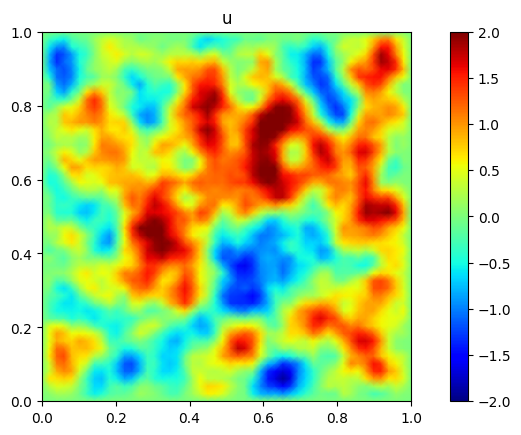

In [15]:
fig = plt.figure()
if dim == 2:
    grid, U = construct_grid(X, u, shape=N_full)
    X1, X2 = grid
    c = plt.pcolormesh(X1, X2, U, cmap='jet', shading='gouraud', vmin=-2, vmax=2)
    fig.colorbar(c)
    # plt.title('Matern GRF with Homogeneous Dirichlet BC')
    plt.title("u")
    plt.axis('square')
elif dim == 1:
    plt.plot(X, u)
plt.show()

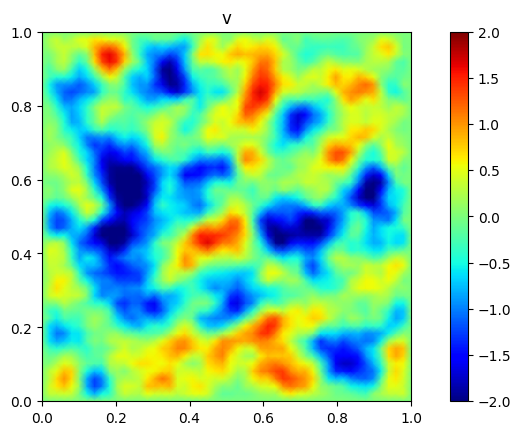

In [16]:
fig = plt.figure()
if dim == 2:
    grid, V = construct_grid(X, v, shape=N_full)
    X1, X2 = grid
    c = plt.pcolormesh(X1, X2, V, cmap='jet', shading='gouraud', vmin=-2, vmax=2)
    fig.colorbar(c)
    # plt.title('Matern GRF with Homogeneous Dirichlet BC')
    plt.title("v")
    plt.axis('square')
elif dim == 1:
    plt.plot(X, v)
plt.show()

In [17]:
def construct_grid(points,values,shape):
    N = points.shape[0]
    dim = points.shape[1]
    grid = tuple(points[:,i].reshape(shape) for i in range(dim))
    vals = values.reshape(shape)
    return grid, vals


In [18]:
grid, U = construct_grid(X, sample, shape=N_full)
X1, X2 = grid
# tuple(X[:,i].reshape(N_full) for i in range(dim))
# grid

In [19]:
N_full

DeviceArray([100, 100], dtype=int64)

In [20]:
X1

DeviceArray([[0.        , 0.        , 0.        , ..., 0.        ,
              0.        , 0.        ],
             [0.01010101, 0.01010101, 0.01010101, ..., 0.01010101,
              0.01010101, 0.01010101],
             [0.02020202, 0.02020202, 0.02020202, ..., 0.02020202,
              0.02020202, 0.02020202],
             ...,
             [0.97979798, 0.97979798, 0.97979798, ..., 0.97979798,
              0.97979798, 0.97979798],
             [0.98989899, 0.98989899, 0.98989899, ..., 0.98989899,
              0.98989899, 0.98989899],
             [1.        , 1.        , 1.        , ..., 1.        ,
              1.        , 1.        ]], dtype=float64)

In [45]:
# def set_zero_bc(U):
#     dim = 

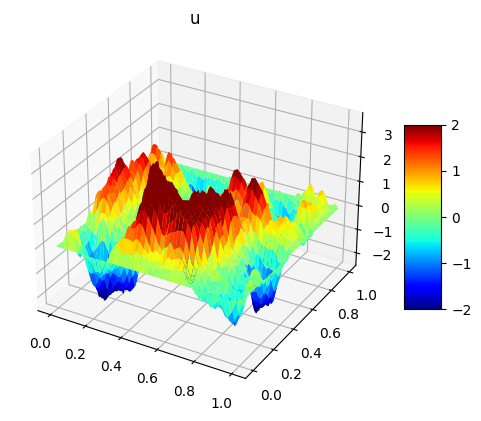

In [21]:
if dim == 2:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    grid, U = construct_grid(X, u, shape=N_full)
    X1, X2 = grid
    surf = ax.plot_surface(X1, X2, U, cmap='jet', linewidth=0, antialiased=True, vmin=-2, vmax=2)
    # c = plt.pcolormesh(X1, X2, U, cmap='jet', shading='gouraud')
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    # plt.title('Matern GRF Dirichlet BC')
    plt.title("u")
    # plt.axis('square')
    
    plt.show()

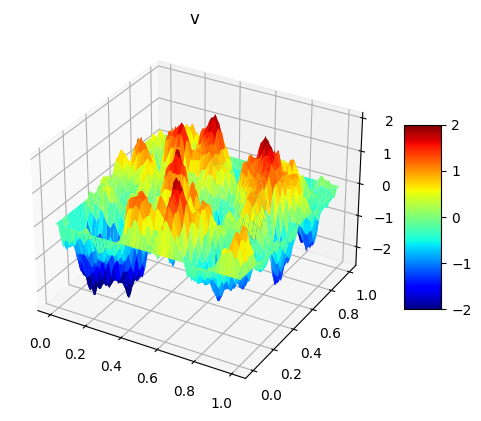

In [47]:
if dim == 2:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    grid, V = construct_grid(X, v, shape=N_full)
    X1, X2 = grid
    surf = ax.plot_surface(X1, X2, V, cmap='jet', linewidth=0, antialiased=True, vmin=-2, vmax=2)
    # c = plt.pcolormesh(X1, X2, V, cmap='jet', shading='gouraud')
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    # plt.title('Matern GRF Dirichlet BC')
    plt.title("v")
    # plt.axis('square')
    
    plt.show()

In [48]:
a,b = grid

In [37]:
file = "data5.h5"
with h5py.File(file, 'w') as hf:
    hf.create_dataset('u', data=U)
    hf.create_dataset('v', data=V)
    for i in range(dim):
        coord_name = f"x{i+1}"
        hf.create_dataset(coord_name, data=x[i])

In [169]:
fig = plt.figure()
c = plt.pcolormesh(K0, cmap='jet', shading='gouraud')
fig.colorbar(c)
plt.show()


KeyboardInterrupt: 

In [18]:
def neumann_mattern(x1, x2=None, l=0.1, sigma=1.0, nu=1.5):
    # do even only 
    d = x1.shape[1]
    N = jnp.int64(jnp.power(x1.shape[0],1.0/d))
    # N = 2 * (N - N//2)
    L = x1[-1] - x1[0]
    N_full = jnp.array([N] * d)
    N_tot = jnp.prod(N_full)
    alpha = nu + 0.5*d
    a1 = jnp.sqrt(2.0/L)
    a0 = jnp.sqrt(1.0/L)
    kappa = jnp.sqrt(2*nu)/l
    eta2 = sigma*(4.0*jnp.pi)**(0.5*d)*gamma(alpha)/(kappa**d * gamma(nu))
    k = [jnp.linspace(0, N-1, N) for _ in range(d)]
    k_grid = jnp.meshgrid(*k, indexing='ij')
    K = jnp.zeros((N_tot, d))
    ones = jnp.ones((N))
    a = [ones*a1[i] for i in range(d)]
    a = [a[i].at[0].set(a0[i]) for i in range(d)]
    a_grid = jnp.meshgrid(*a, indexing='ij')
    A = jnp.zeros((N_tot, d)) # probably inefficient to do it like this, but it nicely keeps track of when k_i is 0 which requires us to use a0 instead of a
    for i in range(d):
        K = K.at[:, i].set(k_grid[i].ravel())
        A = A.at[:, i].set(a_grid[i].ravel())
    # print(jnp.linalg.norm(K, axis=1))
    # Lnorm = jnp.linalg.norm(L)
    # Lval = L[0] # this is from coppying the paper, I think we may need to use the Norm of L
    Knorm = jnp.linalg.norm(K/L, axis=1)
    eigs_k = 1 + (jnp.pi/(kappa))**2 * Knorm**2
    # print(jnp.sum(K*x1, axis=1).shape)
    eigs_k = eigs_k[:, None]
    Kx1 = jnp.expand_dims(K,1)*x1
    wk = jnp.prod(A*jnp.cos(jnp.pi/L * Kx1), axis=2)
    if x2 is not None:
        Kx2 = jnp.expand_dims(K,1)*x2
        wk_star = jnp.prod(A*jnp.cos(jnp.pi/L * Kx2), axis=2).T
    else:
        wk_star = wk.T
    
    cov = eta2 * (wk_star @ (wk * eigs_k**(-alpha)))
    
    return cov
    
    

In [19]:
Kn = neumann_mattern(X)
Ln = jnp.linalg.cholesky(Kn + jitter*jnp.eye(Ntot))

In [20]:
key = random.PRNGKey(12345)
u_rand = random.normal(key, (Ntot,))
sample = jnp.dot(Ln, u_rand).T
jnp.float32(sample).shape

(2500,)

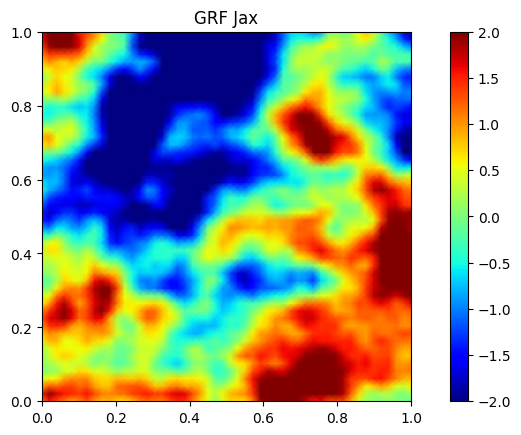

In [21]:
fig = plt.figure()
if dim == 2:
    grid, U = construct_grid(X, sample, shape=N_full)
    X1, X2 = grid
    c = plt.pcolormesh(X1, X2, U, cmap='jet', shading='gouraud', vmin=-2, vmax=2)
    fig.colorbar(c)
    plt.title('GRF Jax')
    plt.axis('square')
elif dim == 1:
    plt.plot(X, sample)
plt.show()

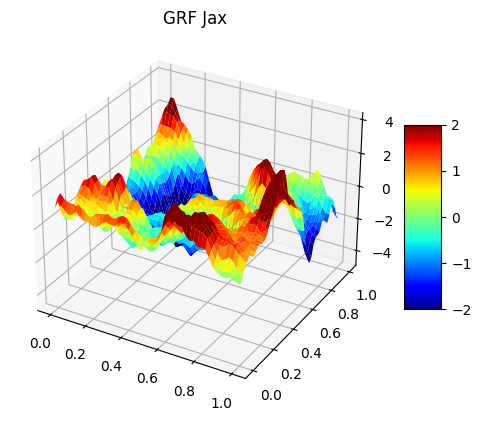

In [22]:
if dim == 2:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    grid, U = construct_grid(X, sample, shape=N_full)
    X1, X2 = grid
    surf = ax.plot_surface(X1, X2, U, cmap='jet', linewidth=0, antialiased=True, vmin=-2, vmax=2)
    # c = plt.pcolormesh(X1, X2, U, cmap='jet', shading='gouraud')
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('GRF Jax')
    # plt.axis('square')
    
    plt.show()

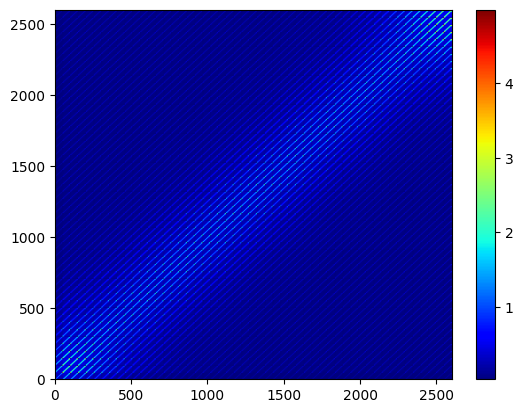

In [ ]:
fig = plt.figure()
c = plt.pcolormesh(Kn, cmap='jet', shading='gouraud')
fig.colorbar(c)
plt.show()


In [5]:
def periodic_mattern_old(x1, x2=None, Nk=None, l=0.1, sigma=1.0, nu=1.5):
    # do even only 
    d = x1.shape[1]
    L = x1[-1] - x1[0]
    if Nk is None:
        Nk = jnp.int64(jnp.power(x1.shape[0],1.0/d))    # N = 2 * (N - N//2)
    N_full = jnp.array([Nk] * d)
    N_tot = jnp.prod(N_full)
    alpha = nu + 0.5*d
    a = jnp.sqrt(2.0/L)
    a0 = jnp.sqrt(1.0/L)
    kappa = jnp.sqrt(2*nu)/l
    eta2 = sigma*(4.0*jnp.pi)**(0.5*d)*gamma(alpha)/(kappa**d * gamma(nu))
    # k = [jnp.linspace(-N//2, N//2 - 1, N) for _ in range(d)]
    k = [jnp.fft.fftshift(jnp.fft.fftfreq(N, 1.0/N)) for _ in range(d)]
    k_grid = jnp.meshgrid(*k, indexing='ij')
    K = jnp.zeros((N_tot, d))
    for i in range(d):
        K = K.at[:, i].set(k_grid[i].ravel())
    Knorm = jnp.linalg.norm(K/L, axis=1)
    eigs_k = 1 + (2.0*jnp.pi/(kappa))**2 * Knorm**2
    
    Kx1 = jnp.expand_dims(K,1)*x1
    wk = jnp.sum(jnp.exp(2.0*jnp.pi*1j/L * Kx1), axis=2)
    if x2 is not None:
        Kx2 = jnp.expand_dims(K,1)*x2
        wk_star = jnp.sum(jnp.exp(-2.0*jnp.pi*1j/L * Kx2), axis=2).T
    else:
        wk_star = jnp.conj(wk).T
    
    cov = eta2/jnp.prod(L) * (wk_star @ (wk * eigs_k**(-alpha)))
    # if x2 is None:
    #     x2 = x1
    # diff = (jnp.expand_dims(x1, 1) - jnp.expand_dims(x2, 0))
    # kdiff = jnp.array([jnp.sum(ki*diff, axis=2) for ki in K])
    # exp = jnp.exp(2.0*jnp.pi*1j/L * kdiff)
    # cov = eta2/jnp.prod(L) * jnp.sum(eigs_k**(-alpha)*exp, axis=0)
    
    return cov
    # # print(jnp.sum(K*x1, axis=1).shape)
    # cov = jnp.zeros((N, N))
    # # for i in range(N):
    # #     k_ = K[i]
    # #     eig = eigs_k[i]
    # #     kx_diff = jnp.sum(k_/L * diff, axis=2)
    # #     cov = cov + eta2/jnp.prod(L) * eig**(-alpha) * jnp.exp(2.0*jnp.pi * 1j * kx_diff)
    # Kx1 = jnp.expand_dims(K,1)*x1
    # wk = jnp.sum(jnp.exp(2.0*jnp.pi*1j/L * Kx1), axis=2)
    # if x2 is not None:
    #     Kx2 = jnp.expand_dims(K,1)*x2
    #     wk_star = jnp.prod(a*jnp.sin(jnp.pi/L * Kx2), axis=2).T
    # else:
    #     wk_star = wk.T
    
    # cov = eta2 * (wk_star @ (wk * eigs_k**(-alpha)))
    
    # return cov
    
    


In [6]:
def periodic_mattern(x1, x2=None, Nk=None, l=0.1, sigma=1.0, nu=1.5):
    # do even only 
    d = x1.shape[1]
    L = x1[-1] - x1[0]
    if Nk is None:
        Nk = jnp.int64(jnp.power(x1.shape[0],1.0/d))    # N = 2 * (N - N//2)
    # N = 2 * (N - N//2)
    N_full = jnp.array([N] * d)
    N_tot = jnp.prod(N_full)
    alpha = nu + 0.5*d
    a1 = jnp.sqrt(2.0/L)
    a0 = jnp.sqrt(1.0/L)
    kappa = jnp.sqrt(2*nu)/l
    
    eta2 = sigma*(4.0*jnp.pi)**(0.5*d)*gamma(alpha)/(kappa**d * gamma(nu))
    k = [jnp.linspace(0, N-1, N) for _ in range(d)]
    k_grid = jnp.meshgrid(*k, indexing='ij')
    
    K = jnp.zeros((N_tot, d))
    ones = jnp.ones((N))
    a = [ones*a1[i] for i in range(d)]
    a = [a[i].at[0].set(a0[i]) for i in range(d)]
    a_grid = jnp.meshgrid(*a, indexing='ij')
    A = jnp.zeros((N_tot, d)) # probably inefficient to do it like this, but it nicely keeps track of when k_i is 0 which requires us to use a0 instead of a
    for i in range(d):
        K = K.at[:, i].set(k_grid[i].ravel())
        A = A.at[:, i].set(a_grid[i].ravel())
    # print(jnp.linalg.norm(K, axis=1))
    # Lnorm = jnp.linalg.norm(L)
    # Lval = L[0] # this is from coppying the paper, I think we may need to use the Norm of L
    Knorm = jnp.linalg.norm(K/L, axis=1)
    eigs_k = 1 + (2.0*jnp.pi/(kappa))**2 * Knorm**2
    # print(jnp.sum(K*x1, axis=1).shape)
    eigs_k = eigs_k[:, None]
    Kx1 = jnp.expand_dims(K,1)*x1
    wk = jnp.prod(a1*(jnp.cos(2*jnp.pi/L * Kx1) + jnp.sin(2*jnp.pi/L * Kx1)), axis=2)
    if x2 is not None:
        Kx2 = jnp.expand_dims(K,1)*x2
        wk_star = jnp.prod(A*(jnp.cos(2*jnp.pi/L * Kx2) + jnp.sin(2*jnp.pi/L * Kx2)), axis=2).T
    else:
        wk_star = wk.T
    
    cov = eta2 * (wk_star @ (wk * eigs_k**(-alpha)))
    
    return cov
    
    

In [7]:
# num = 1
dim = 2
N = 100
N_full = jnp.array([N]*dim)
Ntot = jnp.prod(N_full)
length_scale = 0.1
jitter = 1e-13
x = [jnp.linspace(0, 1, N) for i in range(dim)]
grid = jnp.meshgrid(*x, indexing='ij')
X = jnp.zeros((Ntot, dim))
for i in range(dim):
    X = X.at[:,i].set(grid[i].ravel())
# X = jnp.linspace(0, 1, N)[:, None]


In [8]:
Kper = periodic_mattern(X)
# KperR = jnp.absolute(Kper)
# KperR = jnp.real(Kper)
Lper = jnp.linalg.cholesky(Kper + jitter*jnp.eye(Ntot))
# Lper = jnp.linalg.cholesky(KperR + 1e0*jnp.eye(Ntot)

In [9]:
Lper

DeviceArray([[ 1.23478728e+00,  0.00000000e+00,  0.00000000e+00, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             [ 1.32386014e+00,  1.03904830e-01,  0.00000000e+00, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             [ 1.38333159e+00,  1.37097960e-01,  9.68922170e-02, ...,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             ...,
             [ 9.96702627e-01, -3.09367882e-01,  9.13123604e-02, ...,
               4.48403289e-07,  0.00000000e+00,  0.00000000e+00],
             [ 1.12085387e+00, -1.38932671e-01,  6.76467207e-02, ...,
               9.99935027e-10,  4.46637488e-07,  0.00000000e+00],
             [ 1.23478728e+00,  1.02575993e-12, -3.00986008e-13, ...,
               2.11492588e-11, -3.59824073e-10,  3.65191379e-07]],            dtype=float64)

In [10]:
key = random.PRNGKey(1234)
u_rand = random.normal(key, (Ntot,))
sample = jnp.dot(Lper, u_rand).T
jnp.float32(sample).shape

(10000,)

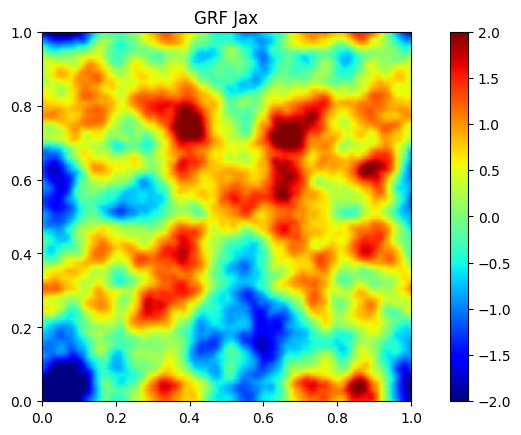

In [11]:
fig = plt.figure()
if dim == 2:
    grid, U = construct_grid(X, sample, shape=N_full)
    X1, X2 = grid
    c = plt.pcolormesh(X1, X2, U, cmap='jet', shading='gouraud', vmin=-2, vmax=2)
    fig.colorbar(c)
    plt.title('GRF Jax')
    plt.axis('square')
elif dim == 1:
    plt.plot(X, sample)
plt.show()

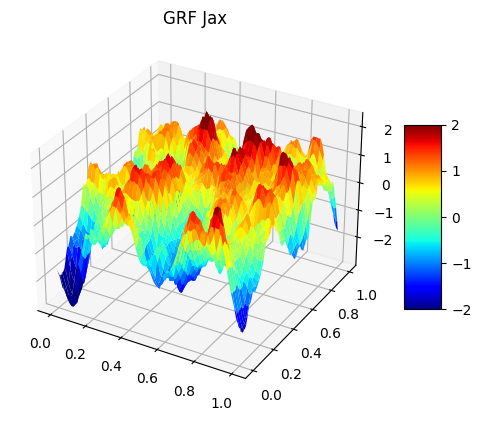

In [12]:
if dim == 2:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    grid, U = construct_grid(X, sample, shape=N_full)
    X1, X2 = grid
    surf = ax.plot_surface(X1, X2, U, cmap='jet', linewidth=0, antialiased=True, vmin=-2, vmax=2)
    # c = plt.pcolormesh(X1, X2, U, cmap='jet', shading='gouraud')
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('GRF Jax')
    # plt.axis('square')
    
    plt.show()

In [17]:
X1[-1]

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

In [13]:
file = "data0.h5"
with h5py.File(file, 'w') as hf:
    hf.create_dataset('u', data=U)
    for i in range(dim):
        coord_name = f"x{i+1}"
        hf.create_dataset(coord_name, data=x[i])

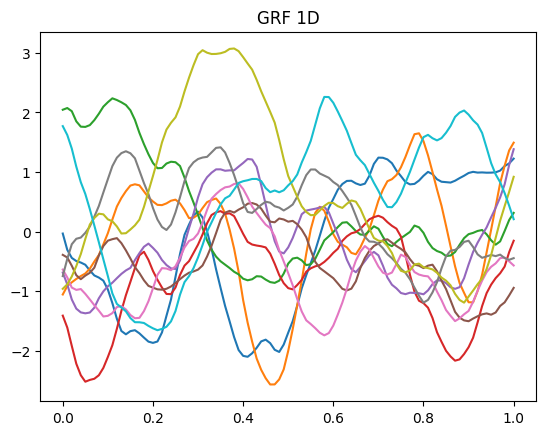

In [22]:
num_1d = 10
T_1d = 1
length_scale_1d = 0.1
N_1d = 1024
n_coord_1d = 101
space_1d = GRF_nd(T_1d, dim=1, kernel="AE", length_scale=length_scale_1d, N=N_1d, interp="linear", nu=2)
sensors_1d = np.linspace(0, T_1d, n_coord_1d)
features_1d = space_1d.random(num_1d)
sensor_values_1d = space_1d.eval_u(features_1d, sensors_1d)
fig = plt.figure()
for y in sensor_values_1d:
    plt.plot(sensors_1d, y)
plt.title('GRF 1D')
plt.show()
# fig = plt.figure()
# c = plt.pcolormesh(X_2d, Y_2d, U_2d, cmap='jet', shading='gouraud')
# fig.colorbar(c)
# plt.title('GRF 2D')
# plt.axis('square')
# plt.show()


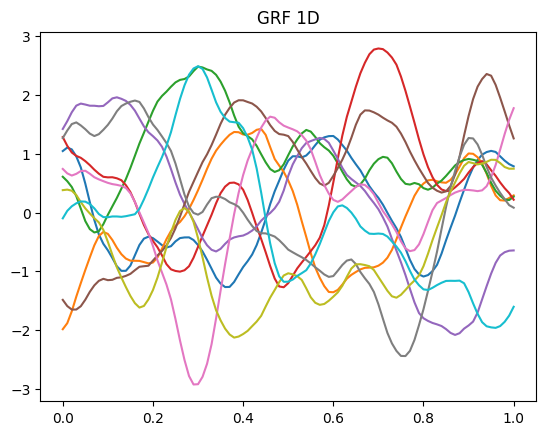

array([[1.00000000e+00, 9.99952224e-01, 9.99808910e-01, ...,
        2.34476307e-22, 2.12670956e-22, 1.92874985e-22],
       [9.99952224e-01, 1.00000000e+00, 9.99952224e-01, ...,
        2.58492679e-22, 2.34476307e-22, 2.12670956e-22],
       [9.99808910e-01, 9.99952224e-01, 1.00000000e+00, ...,
        2.84941713e-22, 2.58492679e-22, 2.34476307e-22],
       ...,
       [2.34476307e-22, 2.58492679e-22, 2.84941713e-22, ...,
        1.00000000e+00, 9.99952224e-01, 9.99808910e-01],
       [2.12670956e-22, 2.34476307e-22, 2.58492679e-22, ...,
        9.99952224e-01, 1.00000000e+00, 9.99952224e-01],
       [1.92874985e-22, 2.12670956e-22, 2.34476307e-22, ...,
        9.99808910e-01, 9.99952224e-01, 1.00000000e+00]])

In [41]:
num_2d = 1
T_2d = 2
N_2d = 100
length_scale_2d = 0.05
n_coord_2d = 64
space_2d = GRF_nd(T_2d, dim=2, length_scale=0.1, N=N_2d, interp="linear",)
sensors_2d = space_2d.x
features_2d = space_2d.random(num_2d)
sensor_values_2d = space_2d.eval_u(features_2d, sensors_2d)


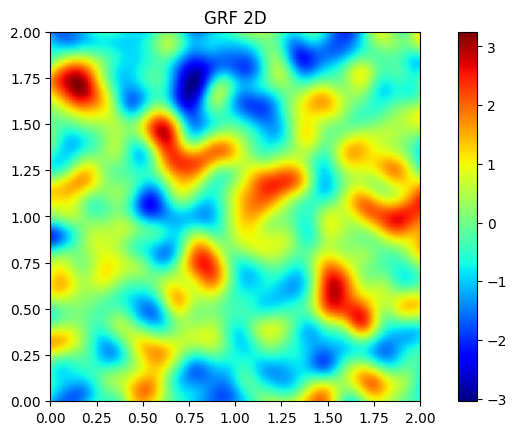

In [42]:

grid_2d, U_2d = construct_grid(sensors_2d, sensor_values_2d, shape=space_2d.N)
X_2d, Y_2d = grid_2d
fig = plt.figure()
c = plt.pcolormesh(X_2d, Y_2d, U_2d, cmap='jet', shading='gouraud')
fig.colorbar(c)
plt.title('GRF 2D')
plt.axis('square')
plt.show()


In [46]:
num_2d = 4
T_2d = 1
N_2d = 100
length_scale_2d = 0.1
n_coord_2d = 64
space_2d = GRF_nd(T_2d, dim=2, length_scale=0.1, N=N_2d, interp="linear", kernel="AE", nu=1.5)
sensors_2d = space_2d.x
features_2d = space_2d.random(num_2d)
sensor_values_2d = space_2d.eval_u(features_2d, sensors_2d)


In [51]:
display(sensors_2d)
display(features_2d[0][:, None])

array([[0.        , 0.        ],
       [0.        , 0.01010101],
       [0.        , 0.02020202],
       ...,
       [1.        , 0.97979798],
       [1.        , 0.98989899],
       [1.        , 1.        ]])

array([[ 0.2911471 ],
       [ 0.3742209 ],
       [ 0.24830377],
       ...,
       [-0.54127688],
       [-0.41327145],
       [-0.20909788]])

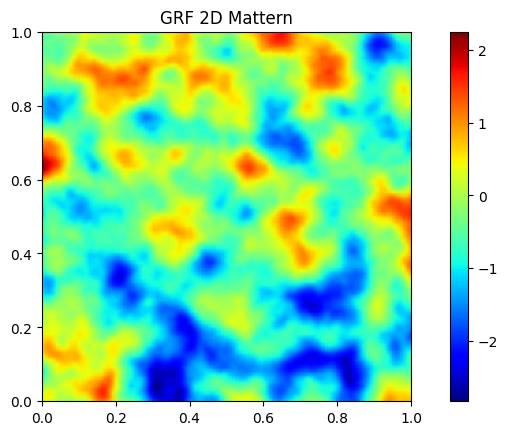

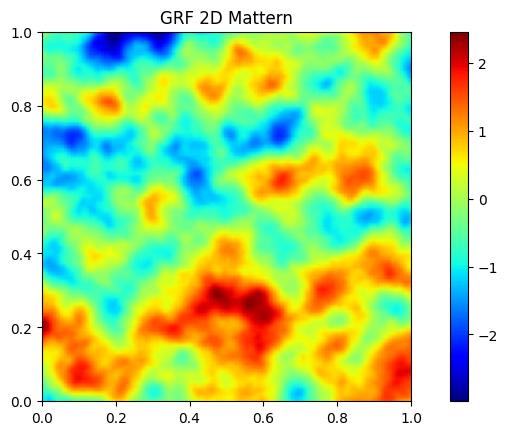

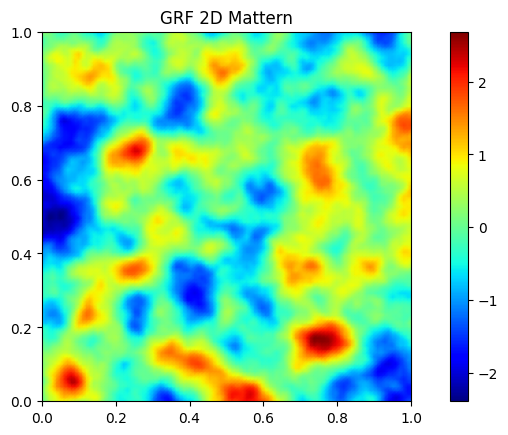

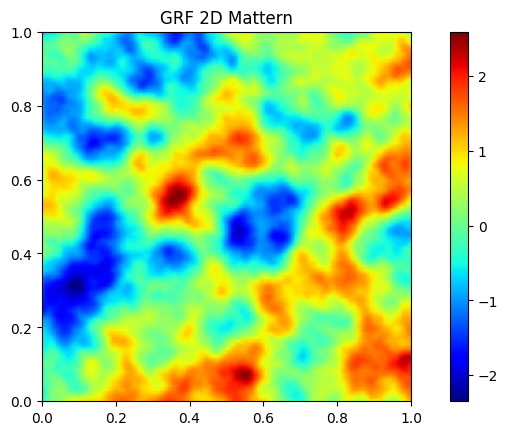

In [48]:
for i in range(num_2d):
    grid_2d, U_2d = construct_grid(sensors_2d, sensor_values_2d[i], shape=space_2d.N)
    X_2d, Y_2d = grid_2d
    fig = plt.figure()
    c = plt.pcolormesh(X_2d, Y_2d, U_2d, cmap='jet', shading='gouraud')
    fig.colorbar(c)
    plt.title('GRF 2D Mattern')
    plt.axis('square')
plt.show()


In [36]:
space_2d.x
space_1d.x

array([[0.00000000e+00],
       [9.77517107e-04],
       [1.95503421e-03],
       ...,
       [9.98044966e-01],
       [9.99022483e-01],
       [1.00000000e+00]])

In [24]:
display(space_1d.L)

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99952224e-01, 9.77493757e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99808910e-01, 1.95480071e-02, 1.35126255e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.34476307e-22, 2.45807956e-21, 1.82026453e-20, ...,
        4.31133141e-07, 0.00000000e+00, 0.00000000e+00],
       [2.12670956e-22, 2.23178007e-21, 1.65438515e-20, ...,
        2.67569194e-07, 4.30951474e-07, 0.00000000e+00],
       [1.92874985e-22, 2.02611896e-21, 1.50347569e-20, ...,
        3.48186078e-07, 2.66081105e-07, 4.31110186e-07]])

In [12]:
sensors = space.x
features = space.random(num)
sensor_values = space.eval_u(features, sensors)


In [10]:

grid,U = construct_grid(sensors, sensor_values, shape=space.N)
X,Y = grid
fig = plt.figure()
c = plt.pcolormesh(X,Y,U,cmap='jet',shading='gouraud')
fig.colorbar(c)
plt.title('GRF 2D')
plt.axis('square')
plt.show()

NameError: name 'sensor_values' is not defined

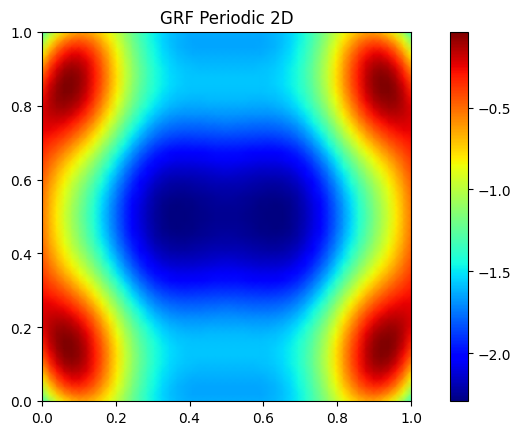

In [51]:
num = 1
space = GRF_nd(1, dim=2, length_scale=0.5, N=50, interp="cubic")
sensors = space.x
features = space.random(num)
sensor_values = space.eval_u(features, np.sin(np.pi*sensors))
grid,U = construct_grid(sensors, sensor_values, shape=space.N)
X,Y = grid
fig = plt.figure()
c = plt.pcolormesh(X,Y,U,cmap='jet',shading='gouraud')
fig.colorbar(c)
plt.title('GRF Periodic 2D')
plt.axis('square')
plt.show()

(0.0, 1.0, 0.0, 1.0)

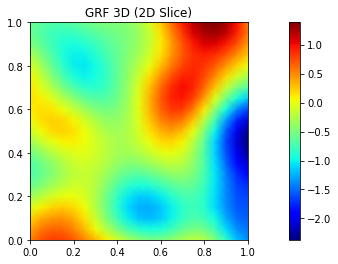

In [5]:
num = 1
space = GRF_nd(1, dim=3, length_scale=0.2, N=21, interp="linear") # no cubic interpolation for 3D
sensors = space.x
features = space.random(num)
sensor_values = space.eval_u(features, sensors)
grid,U = construct_grid(sensors, sensor_values, shape=space.N)
X,Y,Z = grid
fig = plt.figure()
c = plt.pcolormesh(X[...,0],Y[...,0],U[...,0],cmap='jet',shading='gouraud')
fig.colorbar(c)
plt.title('GRF 3D (2D Slice)')
plt.axis('square')

In [6]:
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')

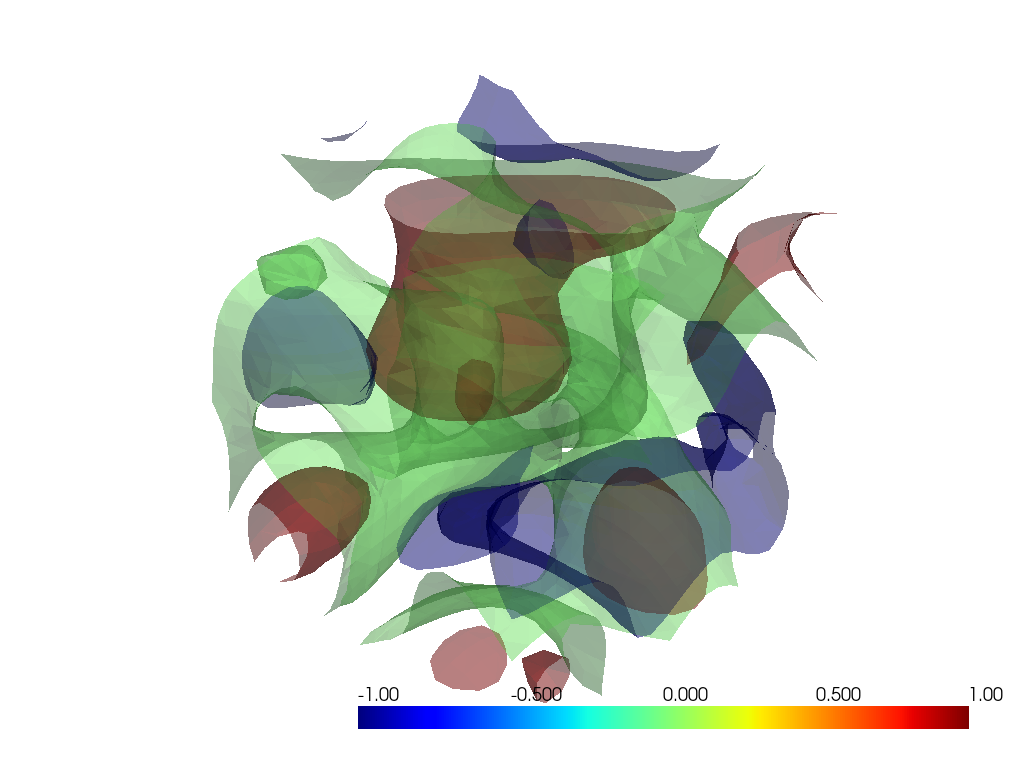

In [12]:
from numpy import cos, pi, mgrid
import pyvista as pv

#%% Data
# x, y, z = pi*mgrid[-1:1:31j, -1:1:31j, -1:1:31j]
# vol = cos(x) + cos(y) + cos(z)
grid = pv.StructuredGrid(X, Y, Z)
grid["vol"] = U.flatten()
contours = grid.contour([-1,0,1],scalars='vol')

#%% Visualization
pv.set_plot_theme('document')
pv.set_jupyter_backend('static')

p = pv.Plotter()
p.add_mesh(contours, scalars=contours.active_scalars, clim=[-1,1], cmap='jet', opacity=0.5)
p.show()


In [11]:
# !jupyter nbextension enable --py --sys-prefix ipygany

Enabling notebook extension ipygany/extension...
      - Validating: ok


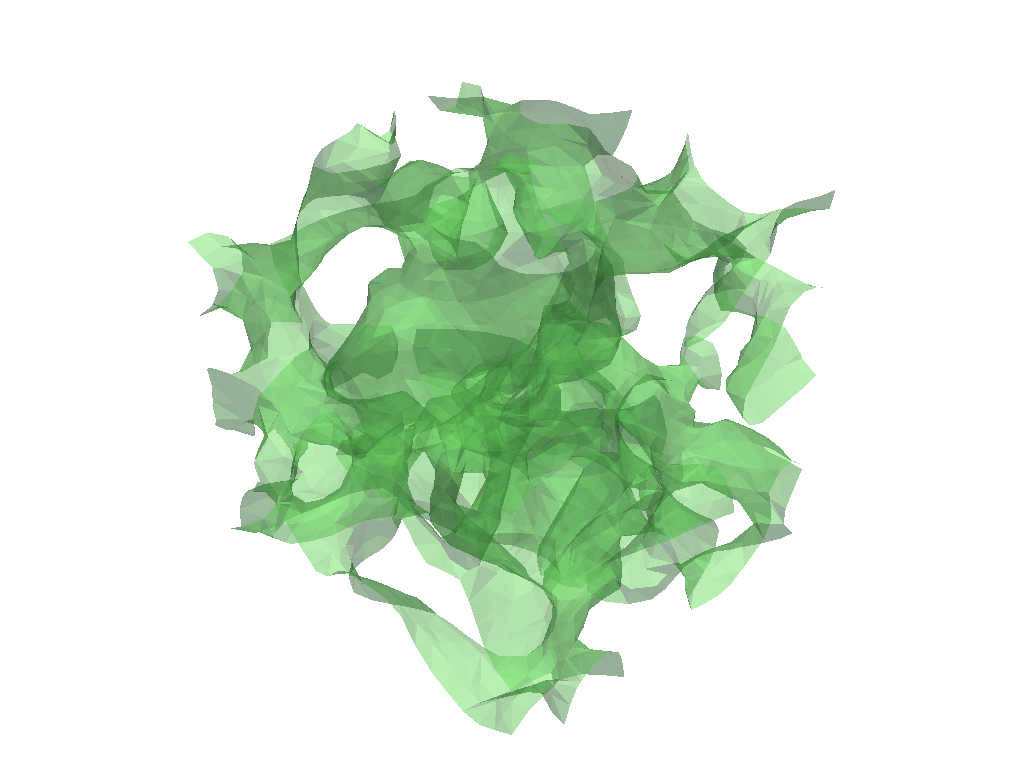

In [24]:
# sargs = dict(interactive=True)  # Simply make the bar interactive
pv.set_jupyter_backend('static')

p = pv.Plotter()

p.add_mesh(contours, scalars=contours.active_scalars, clim=[-1,1], cmap='jet', opacity=0.5, show_scalar_bar=False)
p.show()


In [68]:
U.min()

-3.003755625801002

In [39]:
grid['vol']

array([-0.93646707, -0.72864785, -0.6952657 , ...,  0.54616783,
        1.29029063,  1.50806775])

In [47]:
contours.active_scalars

pyvista_ndarray([0.04960102, 0.03451024, 0.03388413, ..., 1.        ,
                 1.        , 1.        ])